# Multi-instrument, multi-wavelength study of high energy sources with the Virtual Observatory

François Bonnarel¹, Caroline Bot¹, Françoise Genova¹, René Goosmann¹, Ada Nebot¹.

1. Université de Strasbourg, CNRS, Observatoire Astronomique de Strasbourg, UMR 7550, F-67000, Strasbourg, France

This Notebook is based on the Euro-VO "Multi-instrument, multi-wavelength study of high energy sources with the Virtual Observatory" tutorial http://www.euro-vo.org/sites/default/files/documents/tutorial-highenergy_2016Nov.pdf. 

Developed by Caroline Bot, François Bonnarel, René Goosmann and Françoise Genova. 
Adapted to a Jupyter Notebook by Ada Nebot. 

![CDS](Data/images/cds.png)

***

## Introduction

This tutorial demonstrates how to use several standard tools of the Virtual Observatory (VO) for data mining and multiple waveband data analysis. The step-by-step application below focuses on applications in the gamma-ray and high energy domain, but also involves observational data from other wavebands. The user may explore how to:

1. query astronomical catalogues in the gamma-ray and high energy spectral band using VO tools
2. cross-correlate catalogues to find an object at different photon energy bands
3. apply selection criteria when extracting sources from a catalogue
4. use the observational measures of the selected objects to explore possible correlations
5. visualize astronomical images from the radio up to the high energy domain
6. display spectral energy distributions obtained from different photometric data sets
   
Schematic view of the scientific rationale of the tutorial: 

![schema](Data/images/schema.png)

In [2]:
from pathlib import Path
import plotly.express as px


from astroquery.simbad import Simbad
from astroquery.vizier import Vizier

import ipyaladin.aladin_widget as ipyal

from astropy import units as u
from astropy.table import Table, join, unique, hstack, vstack
from astropy.coordinates import SkyCoord

## Step #1 - Obtaining all HESS sources from SIMBAD

[![Simbad](https://custom-icon-badges.demolab.com/badge/Simbad-gray.svg?logo=simbad&logoColor=lightblue&logoWidth=20)](https://simbad.u-strasbg.fr/simbad/ "https://simbad.u-strasbg.fr/simbad/")

How to obtain a catalogue of all published HESS sources from the astronomical database SIMBAD.

The High Energy Stereoscopic System (HESS) is a Cherenkov telescope array detecting cosmic gamma-rays in the GeV—TeV  range. Sources detected by HESS include supernova remnants, wind nebulae pulsar pulsars, active galactic nuclei and others. The number of detected sources steadily grows and makes it possible to study certain sub-samples of the HESS catalogue. In the following, the HESS sources should be investigated with respect to their gamma-ray properties obtained from the second Fermi-LAT catalogue.


In [3]:
# Check which are the default fields
Simbad.get_votable_fields()

['main_id', 'coordinates']

In [4]:
# Check the available fields in a Simbad astroquery
Simbad.list_votable_fields()

--NOTES--

1. The parameter filtername must correspond to an existing filter. Filters include: B,V,R,I,J,K.  They are checked by SIMBAD but not astroquery.simbad

2. Fields beginning with rvz display the data as it is in the database. Fields beginning with rv force the display as a radial velocity. Fields beginning with z force the display as a redshift

3. For each measurement catalog, the VOTable contains all fields of the first measurement. When applicable, the first measurement is the mean one. 

Available VOTABLE fields:

bibcodelist(y1-y2)
biblio
cel
cl.g
coo(opt)
coo_bibcode
coo_err_angle
coo_err_maja
coo_err_mina
coo_qual
coo_wavelength
coordinates
dec(opt)
dec_prec
diameter
dim
dim_angle
dim_bibcode
dim_incl
dim_majaxis
dim_minaxis
dim_qual
dim_wavelength
dimensions
distance
distance_result
einstein
fe_h
flux(filtername)
flux_bibcode(filtername)
flux_error(filtername)
flux_name(filtername)
flux_qual(filtername)
flux_system(filtername)
flux_unit(filtername)
fluxdata(filtername)

In [5]:
# Get more information about the field coordinatse
Simbad.get_field_description("otype")

standard name of the object type


To check all available object types in Simbad go to http://simbad.u-strasbg.fr/simbad/sim-display?data=otypes

In [6]:
# Add the field otype and check that it is now included
Simbad.add_votable_fields("otype")
# Add new columns with the RA and Dec in degrees
# (default cols are h:m:s and d:m:s respectively)
Simbad.add_votable_fields("ra(d)")
Simbad.add_votable_fields("dec(d)")

Simbad.get_votable_fields()

['main_id', 'coordinates', 'otype', 'ra(d)', 'dec(d)']

In [7]:
# Query Simbad by catalog containing the keyword 'hess'
# and display the result in pretty notebook format
hess_simbad = Simbad.query_catalog("hess")
hess_simbad.show_in_notebook(display_length=3)

idx,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,RA_d,DEC_d,SCRIPT_NUMBER_ID
,,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,deg,deg,
0,HESS J0232+202,02 32 53.2,+20 16 21,5,5,--,--,0,D,,2007A&A...475L...9A,gamma,38.22170000,20.27250000,1
1,HESS J0534+220,05 34,+22.0,2,2,--,--,0,E,,2008ApJ...682L..41H,gamma,83.50000000,22.00000000,1
2,4FGL J0535.2-6736,05 36 00.01,-67 35 07.5,6,6,--,--,0,D,X,2012ApJ...759..123S,HighMassXBin,84.00004000,-67.58542000,1
3,HD 259440,06 32 59.2566,+05 48 01.160,14,14,0.018,0.016,90,A,O,2020yCat.1350....0G,HighMassXBin,98.24690253,5.80032243,1
4,NAME MONOCEROS NEB,06 38 43,+06 30.2,4,4,31000.000,18000.000,94,E,,1988IRASP.C......0J,SNRemnant,99.67900000,6.50300000,1
5,NAME Vela X,08 33 08.880,-45 11 24.36,7,7,--,--,0,D,,2015ApJS..217....2M,Pulsar,128.28700000,-45.19010000,1
6,NAME Vela Jr SN,08 52.0,-46 20,3,3,--,--,0,E,R,2009BASI...37...45G,SNRemnant,133.00000000,-46.33000000,1
7,2FGL J1019.0-5856,10 19 02.270,-58 56 29.87,7,7,--,--,0,D,,2015ApJS..217....2M,HighMassXBin,154.75945800,-58.94163100,1
8,PSR J1016-58,10 16 21.266,-58 57 11.70,7,7,1213.000,710.000,90,D,R,2015ApJ...814..128K,Pulsar,154.08860800,-58.95325000,1


There are 96 HESS sources in Simbad database. 

Note that we have limited the display to visualise only the first three entries. You can easily navigate through all the entries and you can sort the current view of the table by selecting a particular column.

You can also filter entries using the "Search:" botton, try e.g. to filter the table by HMXB. 
How many HESS sources in Simbad are classified as HMXB? And as SNR?

## Step #2 - Projecting HESS sources onto the Fermi sky

[![Aladin](https://custom-icon-badges.demolab.com/badge/Aladin-gray.svg?logo=aladin&logoColor=purple&logoWidth=20)](https://aladin.cds.unistra.fr/aladin.gml "https://aladin.cds.unistra.fr/aladin.gml")

Display the HESS sources in Galactic coordinates and overlay it on a view of an all-sky image survey conducted with Fermi LAT.

In [8]:
# Display the Fermi color HiPS
aladin = ipyal.Aladin(survey="P/Fermi/color")
aladin

Aladin(options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'overlay_sur…

In [9]:
# Display the sources on top
aladin.add_table(hess_simbad)

/home/manon.marchand/.local/lib/python3.8/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


The HESS sources are overlayed on top of the Fermi images. If you don't see them, zoom out and move around the sky to locate them around the Galactic Plane. 
By selecting a source you will see the main Simbad information of that source at the bottom of the AladinLite widget. You can change the image by selecting the stack layer. 

In [10]:
# Select the "SNR" sources and overlay them
# Note that characters in python need that extra "b"
idx_SNR = hess_simbad["OTYPE"] == [b"SNR"]
aladin.add_table(hess_simbad[idx_SNR])

## Step #3 - Cross-identify HESS and Fermi LAT sources


[![Xmatch](https://custom-icon-badges.demolab.com/badge/Xmatch-gray.svg?logo=xmatch&logoColor=blue&logoWidth=20)](http://cdsxmatch.u-strasbg.fr/ "http://cdsxmatch.u-strasbg.fr/")

Here we will cross-correlate the HESS source list with the complete set of objects appearing in the *3rd Fermi LAT catalogue*. 

Then we use the CDS XMatch service (http://cdsxmatch.u-strasbg.fr/) via the astroquery.XMatch.query module to look for spatial crossmatches

The cross-correlation will create a new, sub-catalogue of all HESS sources found in Simbad that also appear in the 3rd Fermi-LAT catalogue. 

The Fermi Gamma Ray Space Telescope was launched in 2008 and observes astronomical objects across the 10 keV – 300 GeV band. The main instrument of the Fermi satellite is the Large Area Telescope (LAT), an imaging high-energy gamma-ray telescope covering the spectral range of 20 MeV – 300 GeV. The LAT has a very wide field of view, covering 20% of the sky at any time and scanning the complete sky every three hours. In the third Fermi-LAT catalogue (3FGL) all identified Fermi sources after 4 years of continuous survey were published together with basic measurements such as photometric fluxes in different spectral bands, an estimated gamma-ray spectral slope, or a variability flag.

In the following cross-identification process, it is assumed that the HESS source and its Fermi counterpart have an apparent angular distance of less then 1°, which is guided by the average angular resolution of the Fermi-LAT across the gamma-ray waveband. The angular resolution of the Fermi-LAT drops from 3° at 100 MeV to 0.04° at 100 GeV. Choosing a different limit for the angular distance thus favors associations with more objects at the low or at the high energy end of the Fermi-LAT band.

Find the VizieR name of the 3rd Fermi LAT catalogue. 

In [11]:
catalog_list = Vizier.find_catalogs("Fermi LAT catalog")
for k, v in catalog_list.items():
    print(k, ": ", v.description)

VIII/108 :  Radio core dominance of Fermi/LAT-detected AGNs (Pei+, 2020)
IX/67 :  Incremental Fermi LAT 4th source cat. (4FGL-DR3) (Fermi-LAT col., 2022)
J/ApJ/700/597 :  FERMI LAT detected blazars (Abdo+, 2009)
J/ApJ/706/L7 :  The Fermi LAT sky as seen by INTEGRAL/IBIS (Ubertini+, 2009)
J/ApJ/707/L56 :  VLBI and bright Fermi/LAT sources (Kovalev, 2009)
J/ApJ/715/429 :  First Fermi-LAT AGN catalog (1LAC) (Abdo+, 2010)
J/ApJ/718/587 :  The Fermi-AT20G catalog (Mahony+, 2010)
J/ApJ/722/L7 :  Fermi/LAT detected MOJAVE AGNs (Pushkarev+, 2010)
J/ApJ/742/66 :  New Fermi/LAT extragalactic sources (Teng+, 2011)
J/ApJ/744/177 :  VLBA 5GHz observations of Fermi/LAT AGNs (Linford+, 2012)
J/ApJ/753/83 :  Associations to 1FGL sources (Ackermann+, 2012)
J/ApJ/754/121 :  GRBs from Fermi/GBM and LAT (The Fermi Team, 2012)
J/ApJ/756/33 :  X-ray sources near 2 bright {gamma}-ray sources (Cheung+, 2012)
J/ApJ/757/25 :  Fermi/LAT AGN at 5GHz (Linford+, 2012)
J/ApJ/771/57 :  Fermi-LAT flaring gamma-ray sou

Check the list of cadidate catalogs and select the one that interests us, i.e. "Fermi LAT third source catalog (3FGL) (Acero+, 2015)": **J/ApJS/218/23**. VizieR might have several tables associated to this catalog. 
The next step is to see if the catalog has more than one table associated. 
We display table names and metadata:

In [12]:
Vizier.ROW_LIMIT = -1
catalog = Vizier.get_catalogs("J/ApJS/218/23")
print(catalog)
print("Metadata of each table: ")
print(catalog[0].meta)

TableList with 3 tables:
	'0:J/ApJS/218/23/table4' with 19 column(s) and 4984 row(s) 
	'1:J/ApJS/218/23/table8' with 13 column(s) and 3034 row(s) 
	'2:J/ApJS/218/23/table3' with 2 column(s) and 12 row(s) 
Metadata of each table: 
{'ID': 'J_ApJS_218_23_table4', 'name': 'J/ApJS/218/23/table4', 'description': 'LAT 4-year catalog (3034 unique 3FGL sources)'}


There are three tables, each with a different number of columns and rows. To see those of interest, I display their description.

In [13]:
for i in range(len(catalog)):
    print(catalog[i].meta["name"], ": ", catalog[i].meta["description"])
# for tab in catalog:
#    print(tab.meta['name'], ': ' ,tab.meta['description'])

J/ApJS/218/23/table4 :  LAT 4-year catalog (3034 unique 3FGL sources)
J/ApJS/218/23/table8 :  LAT 4-year catalog: spectral information
J/ApJS/218/23/table3 :  Definitions of the analysis flags


I visualise the first element of each table to have an idea of their content. 

In [14]:
table4 = catalog[0]
table4[0]

_3FGL,Na,RAJ2000,DEJ2000,amaj,amin,phi,Sig,F35,S25,Gamma,Mod,Var,Flag,Assoc,TeV,Class,ID,Simbad
,,deg,deg,deg,deg,deg,,1e-05 / (m2 s),fW / m2,,,,,,,,,
str13,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,str2,str1,str12,str18,str1,str5,str26,str6
J0000.1+6545,1,0.038,65.752,0.102,0.078,41,6.8,1.0,13.6,2.41,PL,,3,2FGL J2359.6+6543c,,,,Simbad


In [15]:
table8 = catalog[1]
table8[0]

File,_3FGL,LC,F1,E_F1,F2,E_F2,F3,E_F3,F4,E_F4,F5,E_F5
,,,0.0001 / (m2 s),0.0001 / (m2 s),0.0001 / (m2 s),0.0001 / (m2 s),1e-05 / (m2 s),1e-05 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s)
str13,str13,str2,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0000.1p6545,J0000.1+6545,LC,1.81,0.82,0.69,0.14,1.24,0.23,0.58,0.49,0.28,0.19


In [16]:
table3 = catalog[2]
table3[0]

Flag,Note
int16,str347
1,"Source with TS>35, which went to TS<25 when changing the diffuse model (Section 3.7.3) or the analysis method (Section 3.7.4). Sources with TS<=35 are not flagged with this bit because normal statistical fluctuations can push them to TS<25."


**J/ApJS/218/23/table4** and **J/ApJS/218/23/table8** contain positional and spectral information respectively. 
The first table has several entries for the same source, so before performing the match restric the table to **unique** entries for the same source. We then match the tables based on the names in column **_3FGL** to get all information in a single table. 

In [17]:
table4 = unique(table4, keys="_3FGL")
FERMI = join(
    table4, table8, keys="_3FGL", join_type="inner", metadata_conflicts="silent"
)
print("Number of matches :", len(FERMI))
FERMI[0]

Number of matches : 3034


_3FGL,Na,RAJ2000,DEJ2000,amaj,amin,phi,Sig,F35,S25,Gamma,Mod,Var,Flag,Assoc,TeV,Class,ID,Simbad,File,LC,F1,E_F1,F2,E_F2,F3,E_F3,F4,E_F4,F5,E_F5
,,deg,deg,deg,deg,deg,,1e-05 / (m2 s),fW / m2,,,,,,,,,,,,0.0001 / (m2 s),0.0001 / (m2 s),0.0001 / (m2 s),0.0001 / (m2 s),1e-05 / (m2 s),1e-05 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s)
str13,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,str2,str1,str12,str18,str1,str5,str26,str6,str13,str2,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
J0000.1+6545,1,0.038,65.752,0.102,0.078,41,6.8,1.0,13.6,2.41,PL,,3,2FGL J2359.6+6543c,,,,Simbad,J0000.1p6545,LC,1.81,0.82,0.69,0.14,1.24,0.23,0.58,0.49,0.28,0.19


We have a new table with **3034 FERMI sources with spatial and spectral information**. We move on to cross-match this table with the HESS-Simbad sources. This time the match will be based on positions. 

Lets have a look again a the hess_simbad table and it's content.

In [18]:
hess_simbad[0:5]

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,RA_d,DEC_d,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,deg,deg,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,float64,float64,int32
HESS J0232+202,02 32 53.2,+20 16 21,5,5,--,--,0,D,,2007A&A...475L...9A,gamma,38.22170000,20.27250000,1
HESS J0534+220,05 34,+22.0,2,2,--,--,0,E,,2008ApJ...682L..41H,gamma,83.50000000,22.00000000,1
4FGL J0535.2-6736,05 36 00.01,-67 35 07.5,6,6,--,--,0,D,X,2012ApJ...759..123S,HighMassXBin,84.00004000,-67.58542000,1
HD 259440,06 32 59.2566,+05 48 01.160,14,14,0.018,0.016,90,A,O,2020yCat.1350....0G,HighMassXBin,98.24690253,5.80032243,1
NAME MONOCEROS NEB,06 38 43,+06 30.2,4,4,31000.000,18000.000,94,E,,1988IRASP.C......0J,SNRemnant,99.67900000,6.50300000,1


In [19]:
# Create a skycoord object from the RA_d and DEC_d columns
c_hess_simbad = SkyCoord(hess_simbad["RA_d"], hess_simbad["DEC_d"])
c_fermi = SkyCoord(FERMI["RAJ2000"], FERMI["DEJ2000"])

In [20]:
# Set the maximum separation
max_sep = 1.0 * u.deg
# For each row in the first catalog, look for the closest neighbor
idx, d2d, d3d = c_hess_simbad.match_to_catalog_sky(c_fermi, 1)
sep_constraint = d2d < max_sep

# limit the tables to matches within the maximum separation
hess_simbad_matches = hess_simbad[sep_constraint]
fermi_matches = FERMI[idx[sep_constraint]]

# Look at the number of matches in each table within the maximum separation
print("Number of possible matches:", len(hess_simbad_matches))
print("Number of possible matches:", len(fermi_matches))

Number of possible matches: 94
Number of possible matches: 94


There are **83 HESS-Simbad-FERMI** possible matches within 1 degree for each row in the first table! 
Tables **hess_simbad_matches** and **fermi_matches** are the matched sources in hess_simbad and fermi, respectively, which are separated by less than 1 deg. But ideally we would like to have the result as a single table including the angular separation between the matches. Let's go do that.

In [21]:
# Add the separation to the fermi Table and concatenate the matched tables
fermi_matches["Ang_Sep"] = d2d[sep_constraint]
hess_simbad_fermi = hstack(
    [hess_simbad_matches, fermi_matches], metadata_conflicts="silent"
)

print("Number of possible matches", len(hess_simbad_fermi))

Number of possible matches 94


Note that the same Fermi source can be associated to different HESS sources. You can investigate those possible matches within 1deg (recommended) or limit to have unique entries. For the purpose of the exercice we choose option 2, but in general, we recommend to look at all possible matches to see which might be the true association (if any). 

In [22]:
# Limit to unique 3FGL sources, this will keep the first row of each duplicate
# Note that one could sort them before that
hess_simbad_fermi.sort("Ang_Sep")
hess_simbad_fermi = unique(hess_simbad_fermi, keys="_3FGL", keep="first")
hess_simbad_fermi.show_in_notebook(display_length=3)

idx,MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,RA_d,DEC_d,SCRIPT_NUMBER_ID,_3FGL,Na,RAJ2000,DEJ2000,amaj,amin,phi,Sig,F35,S25,Gamma,Mod,Var,Flag,Assoc,TeV,Class,ID,Simbad,File,LC,F1,E_F1,F2,E_F2,F3,E_F3,F4,E_F4,F5,E_F5,Ang_Sep
,,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,deg,deg,,,,deg,deg,deg,deg,deg,,1e-05 / (m2 s),fW / m2,,,,,,,,,,,,0.0001 / (m2 s),0.0001 / (m2 s),0.0001 / (m2 s),0.0001 / (m2 s),1e-05 / (m2 s),1e-05 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),deg
0,HESS J0232+202,02 32 53.2,+20 16 21,5,5,--,--,0,D,,2007A&A...475L...9A,gamma,38.22170000,20.27250000,1,J0232.8+2016,1,38.219,20.271,0.055,0.047,-4,7.2,0.4,4.9,2.03,PL,,,,P,bll,1ES 0229+200,Simbad,J0232.8p2016,LC,0.23,0.29,0.18,0.05,0.25,0.11,0.46,0.31,0.42,0.22,0.00294256
1,HESS J0534+220,05 34,+22.0,2,2,--,--,0,E,,2008ApJ...682L..41H,gamma,83.50000000,22.00000000,1,J0534.5+2201,1,83.637,22.024,0.012,0.011,90,30.7,157.3,1471.9,2.23,EC,T,,1FHL J0534.5+2201,P,PSR,PSR J0534+2200,Simbad,J0534.5p2201,LC,6.31,--,3.33,--,14.47,--,90.04,29.86,56.02,2.84,0.12926188
2,HD 259440,06 32 59.2566,+05 48 01.160,14,14,0.018,0.016,90,A,O,2020yCat.1350....0G,HighMassXBin,98.24690253,5.80032243,1,J0633.7+0632,4,98.438,6.541,0.018,0.018,71,57.9,17.1,124.4,2.16,EC,,,2FGL J0633.7+0633,,PSR,LAT PSR J0633+0632,Simbad,J0633.7p0632,LC,8.43,1.05,4.67,0.21,14.08,0.50,25.80,1.61,1.05,0.35,0.76465712
3,NAME Vela X,08 33 08.880,-45 11 24.36,7,7,--,--,0,D,,2015ApJS..217....2M,Pulsar,128.28700000,-45.19010000,1,J0833.1-4511e,3,128.287,-45.190,--,--,--,--,18.3,244.8,2.41,PL,,5,1FHL J0833.1-4511e,E,PWN,Vela X,Simbad,J0833.1-4511e,LC,37.18,--,8.19,--,14.46,--,31.87,--,6.87,--,0.00010275
4,NAME Vela Jr SN,08 52.0,-46 20,3,3,--,--,0,E,R,2009BASI...37...45G,SNRemnant,133.00000000,-46.33000000,1,J0852.7-4631e,3,133.200,-46.520,--,--,--,30.3,13.0,147.1,1.94,PL,T,10,1FGL J0854.0-4632,E,SNR,Vela Jr,Simbad,J0852.7-4631e,LC,9.39,2.21,3.41,0.28,7.54,0.63,19.79,2.39,13.22,1.28,0.23474753
5,PSR J1016-58,10 16 21.266,-58 57 11.70,7,7,1213.000,710.000,90,D,R,2015ApJ...814..128K,Pulsar,154.08860800,-58.95325000,1,J1016.3-5858,2,154.079,-58.967,0.031,0.029,-86,18.9,7.8,65.5,2.35,EC,,5,2FGL J1016.5-5858,E,PSR,PSR J1016-5857,Simbad,J1016.3-5858,LC,7.61,3.73,2.20,0.43,7.33,0.63,13.16,1.51,0.80,0.34,0.01461327
6,2FGL J1019.0-5856,10 19 02.270,-58 56 29.87,7,7,--,--,0,D,,2015ApJS..217....2M,HighMassXBin,154.75945800,-58.94163100,1,J1018.9-5856,4,154.730,-58.946,0.014,0.014,28,52.2,27.1,250.3,2.30,LP,,,1FHL J1018.9-5855,E,HMB,1FGL J1018.6-5856,Simbad,J1018.9-5856,LC,26.67,1.08,11.41,0.55,21.92,0.78,32.61,1.97,1.42,0.43,0.01581526
7,FGES J1023.3-5747,10 23 15.1831,-57 46 34.784,9,9,--,--,0,E,G,2018A&A...612A...1H,gamma,155.81326306,-57.77632889,1,J1023.1-5745,3,155.790,-57.759,0.018,0.018,-32,31.2,19.9,148.1,2.25,EC,,,1FGL J1023.0-5746,E,PSR,LAT PSR J1023-5746,Simbad,J1023.1-5745,LC,0.32,7.01,6.33,0.64,17.51,1.02,25.37,1.96,1.59,0.47,0.02131766
8,PSR J1028-5819,10 28 27.888,-58 19 06.14,7,7,53.000,30.000,90,B,R,2015ApJ...814..128K,Pulsar,157.11620000,-58.31837200,1,J1028.4-5819,5,157.123,-58.320,0.012,0.012,-74,57.5,33.3,251.2,2.18,EC,,,1FHL J1028.4-5819,,PSR,PSR J1028-5819,Simbad,J1028.4-5819,LC,13.98,3.65,9.39,0.68,26.78,0.91,50.11,2.32,3.55,0.60,0.00392618


There are 65 FERMI-HESS-Simbad matches. Some of these associations are of known nature. 


[![Vizier](https://custom-icon-badges.demolab.com/badge/Vizier-gray.svg?logo=vizier&logoColor=orange&logoWidth=20)](https://vizier.cds.unistra.fr/viz-bin/VizieR "https://vizier.cds.unistra.fr/viz-bin/VizieR")

Among the list of catalogs in VizieR that we listed before **J/ApJ/810/14** : *Third catalog of LAT-detected AGNs (3LAC) (Ackermann+, 2015)* lists 3LAC sources classified as AGNS. Let's have a look at the catalogue in question:


In [23]:
Vizier.ROW_LIMIT = -1
catalog = Vizier.get_catalogs("J/ApJ/810/14")
for tab in catalog:
    print(tab.meta["name"], ": ", tab.meta["description"])

J/ApJ/810/14/highlat :  High latitude (|b|>10deg) 3LAC full  sample and fluxes
J/ApJ/810/14/lowlat :  Low latitude (|b|<10deg) sample  and fluxes
J/ApJ/810/14/table7 :  Sources from earlier FGL catalogs missing in 3LAC
J/ApJ/810/14/table10 :  Properties of the 3FGL very-high-energy (VHE) AGNs
J/ApJ/810/14/table2 :  *List of ATCA blazar candidates


Table **J/ApJ/810/14/table10** lists the properties of very-high-energy ANGs. Let's have a look at that table:

In [24]:
table10 = catalog[3]
table10.show_in_notebook(display_length=3)

idx,_3FGL,LL,VHE,SpCl,SEDCl,z,alpha,e_alpha,Var
0,J0013.9-1853,,SHBL J001355.9-185406,bll,HSP,0.094,1.935,0.167,36.46
1,J0033.6-1921,,KUV 00311-1938,bll,HSP,0.610,1.715,0.035,64.62
2,J0035.9+5949,L,1ES J0033+595,bll,HSP,--,1.898,0.042,69.55
3,J0136.5+3905,,RGB J0136+391,bll,HSP,--,1.696,0.025,62.30
4,J0152.6+0148,,RGB J0152+017,bll,HSP,0.080,1.887,0.103,51.76
5,J0222.6+4301,,3C 66A,bll,ISP,0.444,1.880,0.017,885.04
6,J0232.8+2016,,1ES 0229+200,bll,HSP,0.139,2.025,0.150,49.16
7,J0303.4-2407,,PKS 0301-243,bll,HSP,0.260,1.918,0.022,676.85
8,J0316.6+4119,,IC 310,rdg,HSP,0.019,1.902,0.143,38.74
9,J0319.8+1847,,RBS 0413,bll,HSP,0.190,1.572,0.102,76.33


There are no coordinates, only names are given in column **_3FGL**. Let's see how many of these AGNs are within our table of matches **hess_simbad_fermi**:

In [25]:
hess_simbad_fermi_AGN = join(
    hess_simbad_fermi,
    table10,
    keys="_3FGL",
    join_type="inner",
    metadata_conflicts="silent",
)
print("Number of matches :", len(hess_simbad_fermi_AGN))
hess_simbad_fermi_AGN[0]

Number of matches : 5


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,OTYPE,RA_d,DEC_d,SCRIPT_NUMBER_ID,_3FGL,Na,RAJ2000,DEJ2000,amaj,amin,phi,Sig,F35,S25,Gamma,Mod,Var_1,Flag,Assoc,TeV,Class,ID,Simbad,File,LC,F1,E_F1,F2,E_F2,F3,E_F3,F4,E_F4,F5,E_F5,Ang_Sep,LL,VHE,SpCl,SEDCl,z,alpha,e_alpha,Var_2
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,deg,deg,,,,deg,deg,deg,deg,deg,,1e-05 / (m2 s),fW / m2,,,,,,,,,,,,0.0001 / (m2 s),0.0001 / (m2 s),0.0001 / (m2 s),0.0001 / (m2 s),1e-05 / (m2 s),1e-05 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),1e-06 / (m2 s),deg,,,,,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,float64,float64,int32,str13,int16,float32,float32,float32,float32,int16,float32,float32,float32,float32,str2,str1,str12,str18,str1,str5,str26,str6,str13,str2,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,str1,str21,str6,str3,float32,float32,float32,float64
HESS J0232+202,02 32 53.2,+20 16 21,5,5,--,--,0,D,,2007A&A...475L...9A,gamma,38.22170000,20.27250000,1,J0232.8+2016,1,38.219,20.271,0.055,0.047,-4,7.2,0.4,4.9,2.03,PL,,,,P,bll,1ES 0229+200,Simbad,J0232.8p2016,LC,0.23,0.29,0.18,0.05,0.25,0.11,0.46,0.31,0.42,0.22,0.00294256,,1ES 0229+200,bll,HSP,0.139,2.025,0.150,49.16


There are **5 AGNs** ! Let's have a look at their properties and see how they compare with the rest of the population. 

## Step #4 - Searchig for relative locations in a "high-energy color-color diagram"
*How to trace various object properties of a given catalogue against each other and to point out specific sub-samples in the resulting plot.*

The next goal is to look for correlations between different high-energy gamma-ray colors of the HESS sources that are also detected by Fermi. In stellar astronomy, tracing optical colors against each other gives a rather robust classification of different star types without having to do (more ambitious) spectroscopy. In the HESS-FERMI catalogue there is not much spectroscopic information available, but the different fluxes in F1—F5 coming from the 3FGL part can be used to eventually discriminate different sub-samples of the catalogue. Since a color is basically an observed flux ratio between two bands, constructing a color-color diagram has the great advantage to be independent of the distance to the objects.

The “color-color” diagram to be computed involves the following high-energy gamma-ray fluxes as measured by Fermi-LAT:
- F1: flux over 100 – 300 MeV
- F2: flux over 300 - 1000 MeV
- F3: flux over 1 - 3 GeV
- F4: flux over 3 - 10 GeV
- F5: flux over 10 - 100 GeV


Merge all the tables in one, but keeping their origin by adding a column with name **Source**. Add a column for the object type **TYPE**. 

In [26]:
# Create a column with name Source to know  which will contain types as "All" for FERMI,
FERMI["Source"] = "FGL3"
hess_simbad_fermi["Source"] = "HESS-Simbad-3FGL"
hess_simbad_fermi_AGN["Source"] = "AGNs-3LAC"

In [27]:
# Create a column with name TYPE which will contain types as "All" for FERMI,
# Have to change to str since OTYPE is of object type
FERMI["TYPE"] = "ALL"
hess_simbad_fermi["TYPE"] = hess_simbad_fermi["OTYPE"].astype(str)
hess_simbad_fermi_AGN["TYPE"] = "AGN"

In [28]:
# Merge the tables vertically using vstack
Data = vstack(
    [FERMI, hess_simbad_fermi, hess_simbad_fermi_AGN], metadata_conflicts="silent"
)

In [29]:
# Create two new columns with the flux ratios
Data["F2_F1"] = Data["F2"] / Data["F1"]
Data["F4_F3"] = Data["F4"] / Data["F3"]

Save the file into for instance csv format and into a Panda kind of table to be able to use Plotly

In [30]:
# Write Table to csv format and to panda format
Data.write("Data" / Path("Data_FERMI-HESS-SIMBAD-AGN.csv"), overwrite=True)
Data = Data.to_pandas()

And now lets plot using Plotly:
- Flux ratios F2/F1 vs F4/F3
- In a log. scale 
- Color coded according to the Source 
- Using fancy markers 
- Adding a legend

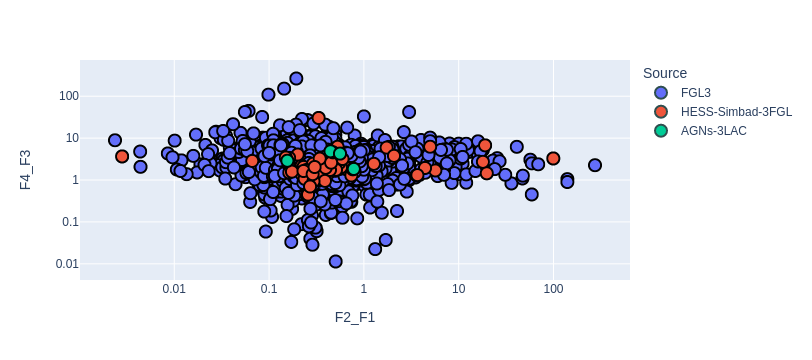

In [31]:
fig = px.scatter(
    Data,
    x="F2_F1",
    y="F4_F3",
    log_x=True,
    log_y=True,
    color="Source",
    hover_name="TYPE",
)
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.show()

Note that when you move around with the mouse you get the values for each of the sources. You can activate or deactivate a type of Source in the plot by selecting it in the legend. You can zoom in and out, you can export as a png... and plenty more. Play a little bit with it. 

Do the same as before but now color coded by object type. 

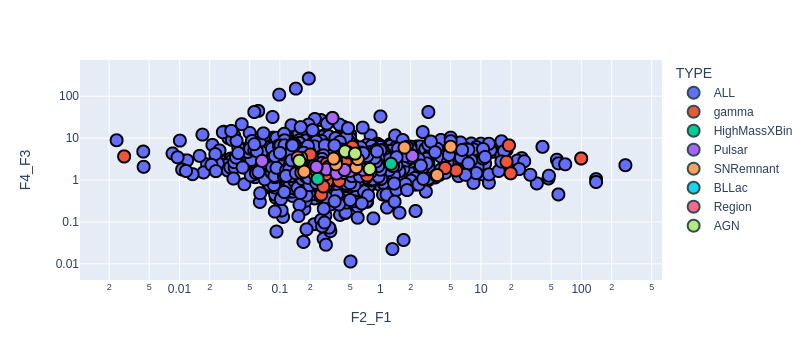

In [32]:
# Plot same thing but color coded by the TYPE of object
fig = px.scatter(Data, "F2_F1", y="F4_F3", log_x=True, log_y=True, color="TYPE")
fig.update_traces(
    marker=dict(size=12, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.show()

## Step #5 – Display the location of interesting sources and search multi-wavelength data around them

*How to obtain multi-wavelength images for the source you are interested in.* 

After isolating the 5 SIMBAD-confirmed BL Lac objects on the gamma-ray “color-color” diagram, this last step focuses on one particular object: **PKS 2155-304, a peculiar BL Lac object known to be very variable on a wide spectral range and to show recurrent outbursts**. A BL Lac object is a sub-type of active galactic nuclei, where the central engine around the accreting supermassive black hole launches magnetized, ballistic jets that reach out to kiloparsec scales while being nearly aligned with the line of sight of the observer. The emission from the jets is modeled as relativistically beamed synchrotron-self-Compton (SSC) emission produced in the hot plasma of the ejected jet material. The very hot electrons produce synchrotron emission that peaks in the radio band and then the very same electrons comptonize the synchrotron photons and up-scatter them to gamma-rays and beyond. However, in reality the question of the seed photons and the structure of the jet are still under investigation. A simple SSC interpretation of the broad band spectrum is challenged by the partially correlated variability seen between different spectral bands.

Broad-band spectrum reaching from the radio to the high-energy band
 (H.E.S.S., Fermi-LAT collaborations, ApJ 696, L150)
 
![SED](Data/images/SED.png)

In the following, this tutorial shows how to obtain multi-waveband imaging for this source (PKS 2155-304).

Now, let's plot again AladinLite with the catalog of AGNs on top on the Fermi image and centering around PKS 2155-30 and setting a field of view of 10 deg.

In [33]:
obj = "PKS 2155-304"
aladin = ipyal.Aladin(target=obj, survey="P/Fermi/color", fov=10)
aladin

Aladin(fov=10.0, options=['allow_full_zoomout', 'coo_frame', 'fov', 'full_screen', 'log', 'overlay_survey', 'o…

In [34]:
aladin.add_table(hess_simbad_fermi)
aladin.add_table(hess_simbad_fermi_AGN)

/home/manon.marchand/.local/lib/python3.8/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



In [39]:
sc = SkyCoord.from_name(obj)
sed_url = f"https://vizier.cds.unistra.fr/viz-bin/sed?-c={sc.icrs.ra.deg},{sc.icrs.dec.deg}&-c.rs=5"
sed = Table.read(sed_url, format="votable")

sed.pprint()

   _RAJ2000      _DEJ2000            _tabname          ... sed_eflux sed_filter
     deg           deg                                 ...     Jy              
------------- ------------- -------------------------- ... --------- ----------
329.716940600 -30.225596400                  I/289/out ...        --   2MASS:Ks
329.716940600 -30.225596400                  I/289/out ...        --    2MASS:H
329.716940600 -30.225596400                  I/289/out ...        --    2MASS:J
329.716940600 -30.225596400                  I/297/out ...        --   2MASS:Ks
329.716940600 -30.225596400                  I/297/out ...        --    2MASS:H
329.716940600 -30.225596400                  I/297/out ...        --    2MASS:J
329.716983000 -30.225589000                  I/305/out ...     0.024  POSS-II:i
329.716983000 -30.225589000                  I/305/out ...     0.012  POSS-II:F
329.716983000 -30.225589000                  I/305/out ...    0.0088  POSS-II:J
329.716983000 -30.225589000             

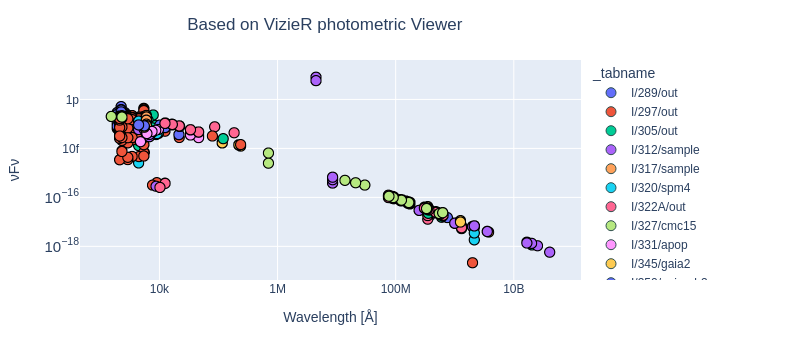

In [36]:
sed["nufnu"] = sed["sed_freq"] * sed["sed_flux"] * 1e-17
cc = 3e18
sed["lambda"] = cc / sed["sed_freq"] / 1e9
sed_p = sed.to_pandas()
fig = px.scatter(sed_p, x="lambda", y="nufnu", log_x=True, log_y=True, color="_tabname")
fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)

fig.update_layout(
    xaxis_title="Wavelength [Å]",
    yaxis_title="νFν",
    title={
        "text": "Based on VizieR photometric Viewer",
        "y": 0.95,
        "x": 0.4,
        "xanchor": "center",
        "yanchor": "top",
    },
)

fig.show()